In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (2*K*8*(N-1)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def hs(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return ((2*i+2*j-h)**2)/h

def SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    d = np.zeros(2)
    N = np.zeros(10)
    
    for k in range(10):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0: N[4] -= 1
            elif N[1] > 0: N[1] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            elif N[2] > 0: N[2] -= 1
            else: N[3] -= 1
            N[9] += 1
            
            T = hs(N)
            d[0] -= 1
        
        T = hs(n)
        for k in range(10):
            N[k] = n[k]
        
        while T < cc:
            if N[6] > 0: N[6] -= 1
            elif N[8] > 0: N[8] -= 1
            elif N[9] > 0: N[9] -= 1
            elif N[2] > 0: N[2] -= 1
            elif N[3] > 0: N[3] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            else: N[1] -= 1
            N[4] += 1
            
            T = hs(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
        
    else:
        step = 0
        
        for k in range(10):
            N[k] = n[k]
            
        if i+j > h/2:
            while T >= cc:
                if N[6] > 0: N[6] -= 1
                elif N[8] > 0: N[8] -= 1
                elif N[9] > 0: N[9] -= 1
                elif N[2] > 0: N[2] -= 1
                elif N[3] > 0: N[3] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                else: N[1] -= 1
                N[4] += 1
                
                T = hs(N)
                step += 1
        else:
            while T >= cc:
                if N[4] > 0: N[4] -= 1
                elif N[1] > 0: N[1] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                elif N[2] > 0: N[2] -= 1
                else: N[3] -= 1
                N[9] += 1
                
                T = hs(N)
                step += 1
                
        return step-1

In [4]:
def appx_SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    if T < cc:
        if i+j >= h/2:
            if h <= cc:
                return -math.ceil((cc-(i+j))/2)
            else:
                return -math.ceil(((h+math.sqrt(h*cc))/2 - (i+j))/2)
        else:
            if h <= cc:
                return -math.ceil((cc-h+i+j)/2)
            else:
                return -math.ceil((i+j - (h-math.sqrt(h*cc))/2)/2)
    else:
        if i+j >= h/2:
            return math.ceil((i+j - (h+math.sqrt(h*cc))/2)/2) - 1
        else:
            return math.ceil(((h-math.sqrt(h*cc))/2 - (i+j))/2)-1

In [5]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

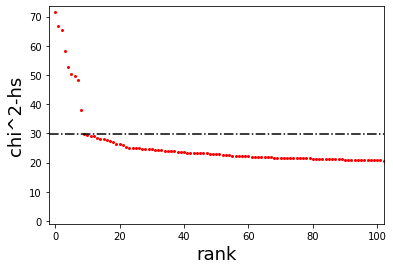

In [6]:
N = 5000
M = 1000000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    n[i][4] = np.random.binomial(2*N, 1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]
    
for i in range(M-10,M):
    n[i][4] = np.random.binomial(2*N, 1.1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1.1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = ((2*I[i] + 2*J[i] - H[i])**2)/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(29.7, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-hs", fontsize = 18)
fig.savefig("stats-hs.png")
fig.savefig("fig/stats-hs.eps")

In [7]:
cc = 29.7
appx_shd = np.zeros(M)
shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_hs(cc,k)
    shd[i] = SHD_hs(cc,k)

print(appx_shd)
print(shd)

[-128. -148. -145. ...   48.   82.  -29.]
[-128. -148. -145. ...   48.   82.  -29.]


In [8]:
def evaluation_Lap(data,epsilon, K, N, M):
    correct = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            if noisy_rank[i] <= K:
                correct += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

In [9]:
def evaluation_Exp(x, appx_shd, shd, epsilon, K, N, M):
    accuracy = np.zeros(2)
    correct = np.zeros(2)
    cc = 29.7
    
    true = np.zeros(K)
    for i in range(K):
        true[i] = x[M-1-i]
        
    APPX = np.zeros(M)
    SHD = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
            SHD[i] = shd[i]
        
        #print(APPX)
        #print(SHD)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        exact_result = exp_mec(SHD, M, K, epsilon)
        #print(appx_result)
        #print(exact_result)
        for k in range(K):
            for l in range(K):
                if appx_result[k] == true[l]:
                    correct[0] += 1
                if exact_result[k] == true[l]:
                    correct[1] += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

[[0.   0.02 0.02]
 [0.   0.82 0.78]
 [0.   1.   1.  ]
 [0.02 1.   1.  ]
 [0.18 1.   1.  ]
 [0.46 1.   1.  ]
 [0.64 1.   1.  ]]
[[0.   0.06 0.04]
 [0.   0.82 0.84]
 [0.   1.   1.  ]
 [0.   1.   1.  ]
 [0.28 1.   1.  ]
 [0.58 1.   1.  ]
 [0.78 1.   1.  ]]
[[0.   0.02 0.  ]
 [0.   0.84 0.84]
 [0.   0.98 0.92]
 [0.02 1.   1.  ]
 [0.36 1.   1.  ]
 [0.68 1.   1.  ]
 [0.74 1.   1.  ]]
[[0.   0.02 0.06]
 [0.   0.88 0.9 ]
 [0.   1.   0.98]
 [0.   1.   1.  ]
 [0.32 1.   1.  ]
 [0.64 1.   1.  ]
 [0.72 1.   1.  ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.04 0.04]
 [0.   0.78 0.78]
 [0.   1.   0.98]
 [0.   1.   1.  ]
 [0.36 1.   1.  ]
 [0.6  1.   1.  ]
 [0.68 1.   1.  ]]


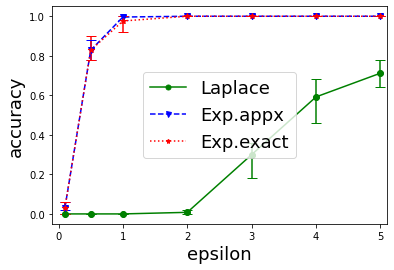

In [10]:
K = 1
N = 5000
M = 1000000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_K=1.png")
fig.savefig("fig/evaluation_hs_K=1.eps")

[[0.   0.01 0.  ]
 [0.   0.7  0.72]
 [0.   0.85 0.76]
 [0.   0.84 0.86]
 [0.   0.92 0.9 ]
 [0.   0.94 0.93]
 [0.04 0.94 1.  ]]
[[0.   0.   0.  ]
 [0.   0.78 0.8 ]
 [0.   0.86 0.78]
 [0.   0.86 0.89]
 [0.   0.87 0.95]
 [0.01 0.98 0.89]
 [0.02 0.98 0.97]]
[[0.   0.   0.  ]
 [0.   0.71 0.71]
 [0.   0.77 0.83]
 [0.   0.86 0.85]
 [0.   0.89 0.91]
 [0.01 0.95 0.91]
 [0.07 0.96 0.95]]
[[0.   0.   0.  ]
 [0.   0.71 0.68]
 [0.   0.81 0.83]
 [0.   0.82 0.82]
 [0.   0.92 0.91]
 [0.   0.92 0.95]
 [0.08 0.97 0.96]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.   0.  ]
 [0.   0.7  0.8 ]
 [0.   0.8  0.82]
 [0.   0.85 0.85]
 [0.   0.88 0.9 ]
 [0.01 0.92 0.93]
 [0.08 0.96 0.99]]


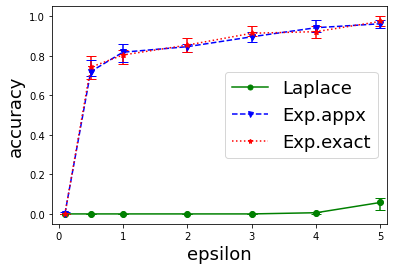

In [11]:
K = 2
N = 5000
M = 1000000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_K=2.png")
fig.savefig("fig/evaluation_hs_K=2.eps")

[[0.         0.         0.        ]
 [0.         0.72       0.74      ]
 [0.         0.94666667 0.98      ]
 [0.         1.         0.98666667]
 [0.         1.         1.        ]
 [0.         1.         0.99333333]
 [0.         1.         1.        ]]
[[0.         0.         0.        ]
 [0.         0.78666667 0.72666667]
 [0.         0.96       0.94666667]
 [0.         1.         0.98666667]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.         1.         1.        ]]
[[0.         0.         0.        ]
 [0.         0.71333333 0.74      ]
 [0.         0.95333333 0.94      ]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.         1.         1.        ]]
[[0.         0.         0.        ]
 [0.         0.74       0.81333333]
 [0.         0.96       0.95333333]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.         1.         1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.         0.        ]
 [0.         0.78666667 0.75333333]
 [0.         0.92666667 0.96      ]
 [0.         1.         0.99333333]
 [0.         1.         1.        ]
 [0.         1.         1.        ]
 [0.01333333 1.         1.        ]]


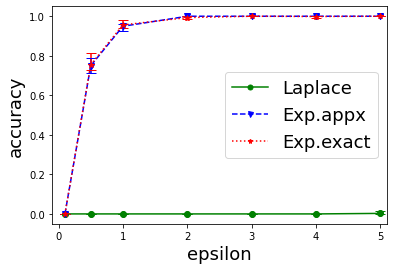

In [12]:
K = 3
N = 5000
M = 1000000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_K=3.png")
fig.savefig("fig/evaluation_hs_K=3.eps")

[[0.    0.    0.   ]
 [0.    0.084 0.108]
 [0.    0.876 0.832]
 [0.    0.916 0.896]
 [0.    0.94  0.916]
 [0.    0.968 0.956]
 [0.004 0.976 0.968]]
[[0.    0.    0.   ]
 [0.    0.084 0.068]
 [0.    0.832 0.84 ]
 [0.    0.908 0.948]
 [0.    0.944 0.936]
 [0.    0.948 0.96 ]
 [0.    0.98  0.964]]
[[0.    0.    0.   ]
 [0.    0.088 0.104]
 [0.    0.848 0.824]
 [0.    0.884 0.944]
 [0.    0.924 0.94 ]
 [0.    0.976 0.968]
 [0.    0.988 0.968]]
[[0.    0.    0.   ]
 [0.    0.072 0.076]
 [0.    0.832 0.836]
 [0.    0.94  0.892]
 [0.    0.94  0.908]
 [0.    0.96  0.944]
 [0.    0.988 0.984]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.    0.    0.   ]
 [0.    0.112 0.076]
 [0.    0.824 0.852]
 [0.    0.9   0.92 ]
 [0.    0.94  0.964]
 [0.    0.96  0.964]
 [0.    0.968 0.984]]


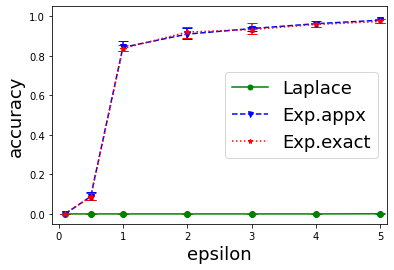

In [13]:
K = 5
N = 5000
M = 1000000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_K=5.png")
fig.savefig("fig/evaluation_hs_K=5.eps")

[[0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.084 0.09 ]
 [0.    0.826 0.806]
 [0.    0.9   0.904]
 [0.    0.91  0.914]
 [0.    0.91  0.908]]
[[0.    0.    0.   ]
 [0.    0.    0.004]
 [0.    0.086 0.104]
 [0.    0.81  0.818]
 [0.    0.904 0.904]
 [0.    0.91  0.914]
 [0.    0.92  0.916]]
[[0.    0.    0.   ]
 [0.    0.    0.002]
 [0.    0.1   0.098]
 [0.    0.816 0.808]
 [0.    0.886 0.91 ]
 [0.    0.9   0.914]
 [0.    0.916 0.92 ]]
[[0.    0.    0.   ]
 [0.    0.004 0.   ]
 [0.    0.092 0.09 ]
 [0.    0.822 0.814]
 [0.    0.898 0.892]
 [0.    0.91  0.912]
 [0.    0.916 0.906]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.    0.    0.   ]
 [0.    0.    0.002]
 [0.    0.1   0.114]
 [0.    0.812 0.818]
 [0.    0.902 0.892]
 [0.    0.904 0.918]
 [0.    0.918 0.916]]


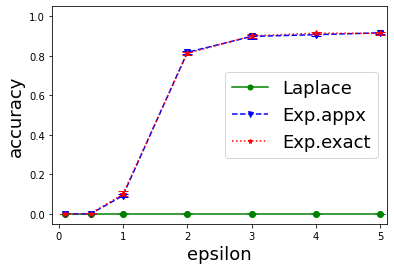

In [14]:
K = 10
N = 5000
M = 1000000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_K=10.png")
fig.savefig("fig/evaluation_hs_K=10.eps")